In [4]:
# Author: Robert Guthrie

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [5]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
EMBEDDING_DIM = 10
raw_text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(raw_text)
vocab_size = len(vocab)

word_to_ix = {word: i for i, word in enumerate(vocab)}
data = []
for i in range(2, len(raw_text) - 2):
    context = [raw_text[i - 2], raw_text[i - 1],
               raw_text[i + 1], raw_text[i + 2]]
    target = raw_text[i]
    data.append((context, target))
print(data[:5])

[(['We', 'are', 'to', 'study'], 'about'), (['are', 'about', 'study', 'the'], 'to'), (['about', 'to', 'the', 'idea'], 'study'), (['to', 'study', 'idea', 'of'], 'the'), (['study', 'the', 'of', 'a'], 'idea')]


In [14]:
class CBOW(nn.Module):

    def __init__(self, vocab_size, embedding_dim, context_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.linear1 = nn.Linear(context_size * 2 * embedding_dim, 128)
        self.linear2 = nn.Linear(128, vocab_size)

    def forward(self, inputs):
        embeds = self.embeddings(inputs).view((1, -1))
        out = F.relu(self.linear1(embeds))
        out = self.linear2(out)
        log_probs = F.log_softmax(out, dim=1)
        return log_probs


In [16]:
# Train

losses = []
loss_function = nn.NLLLoss()
model = CBOW(len(vocab), EMBEDDING_DIM, CONTEXT_SIZE)
optimizer = optim.SGD(model.parameters(), lr=0.001)

for epoch in range(20):
    total_loss = 0
    for context, target in data:

        # Step 1. Prepare the inputs to be passed to the model (i.e, turn the words
        # into integer indices and wrap them in tensors)
        
        context_idxs = torch.tensor([word_to_ix[w] for w in context], dtype=torch.long)

        # Step 2. Recall that torch *accumulates* gradients. Before passing in a
        # new instance, you need to zero out the gradients from the old
        # instance
        model.zero_grad()

        # Step 3. Run the forward pass, getting log probabilities over next
        # words
        log_probs = model(context_idxs)

        # Step 4. Compute your loss function. (Again, Torch wants the target
        # word wrapped in a tensor)
        loss = loss_function(log_probs, torch.tensor([word_to_ix[target]], dtype=torch.long))

        # Step 5. Do the backward pass and update the gradient
        loss.backward()
        optimizer.step()

        # Get the Python number from a 1-element Tensor by calling tensor.item()
        total_loss += loss.item()
    losses.append(total_loss)
print(losses)  # The loss decreased every iteration over the training data!

[226.57362151145935, 225.12537932395935, 223.6888325214386, 222.26223063468933, 220.84522438049316, 219.43796229362488, 218.03797721862793, 216.646582365036, 215.2625868320465, 213.88538694381714, 212.5141794681549, 211.14938139915466, 209.79069328308105, 208.43782377243042, 207.09045839309692, 205.74745559692383, 204.408625125885, 203.07407546043396, 201.74193453788757, 200.41228246688843]


In [17]:
len(vocab), model.embeddings

(49, Embedding(49, 10))

In [18]:
model.embeddings(torch.tensor(0))

tensor([-0.6758, -0.9890,  0.3086, -0.2247,  0.5867,  1.4400, -0.7063, -0.6341,
        -0.6062,  1.6218], grad_fn=<EmbeddingBackward>)

In [19]:
for word in list(vocab)[:5]:
    print(f'{word}: {model.embeddings(torch.tensor(word_to_ix[word]))}')

pattern: tensor([-0.6758, -0.9890,  0.3086, -0.2247,  0.5867,  1.4400, -0.7063, -0.6341,
        -0.6062,  1.6218], grad_fn=<EmbeddingBackward>)
our: tensor([-0.8493, -0.1350,  0.0906, -0.8855, -2.0384,  0.1276,  0.4230, -0.1195,
         1.3539,  1.1452], grad_fn=<EmbeddingBackward>)
data.: tensor([ 0.7426,  0.1515,  0.8686,  0.7733,  2.5940,  1.1159,  0.5394, -1.0189,
         0.2691, -0.6671], grad_fn=<EmbeddingBackward>)
The: tensor([ 2.2242, -1.7128, -1.2612, -0.2710,  1.3530, -0.8377, -1.1382,  0.3425,
        -0.2956, -0.0945], grad_fn=<EmbeddingBackward>)
evolve,: tensor([ 1.8297,  1.4034, -0.8595,  0.9149, -0.1918,  0.2714,  1.1883,  0.3882,
         1.5580, -2.7732], grad_fn=<EmbeddingBackward>)


In [20]:
embeddings = model.embeddings.weight.data.numpy()
embeddings[:5]

array([[-0.6757755 , -0.98896396,  0.308631  , -0.22467665,  0.5867099 ,
         1.4400084 , -0.7063139 , -0.6341386 , -0.606229  ,  1.6217638 ],
       [-0.84926486, -0.13502355,  0.09058   , -0.8854594 , -2.038402  ,
         0.12756713,  0.42304376, -0.11946079,  1.3539026 ,  1.1452372 ],
       [ 0.7426228 ,  0.15148646,  0.8685565 ,  0.7733073 ,  2.5939853 ,
         1.1159067 ,  0.53937125, -1.0188885 ,  0.26908147, -0.6671125 ],
       [ 2.2242174 , -1.712762  , -1.2611614 , -0.2710391 ,  1.3530234 ,
        -0.8377273 , -1.1381783 ,  0.3425029 , -0.29562208, -0.09452835],
       [ 1.8296745 ,  1.4034259 , -0.8595351 ,  0.9148794 , -0.19184558,
         0.2713971 ,  1.1882803 ,  0.38818598,  1.5579695 , -2.7732284 ]],
      dtype=float32)

In [21]:
import pandas as pd
df = pd.DataFrame(data=embeddings)
#df['word'] = vocab
df.head()

,0,1,2,3,4,5,6,7,8,9
0,-0.675776,-0.988964,0.308631,-0.224677,0.586710,1.440008,-0.706314,-0.634139,-0.606229,1.621764
1,-0.849265,-0.135024,0.090580,-0.885459,-2.038402,0.127567,0.423044,-0.119461,1.353903,1.145237
2,0.742623,0.151486,0.868556,0.773307,2.593985,1.115907,0.539371,-1.018888,0.269081,-0.667113
3,2.224217,-1.712762,-1.261161,-0.271039,1.353023,-0.837727,-1.138178,0.342503,-0.295622,-0.094528
4,1.829674,1.403426,-0.859535,0.914879,-0.191846,0.271397,1.188280,0.388186,1.557969,-2.773228


In [22]:
#t-SNE
#https://www.datacamp.com/community/tutorials/introduction-t-sne
#https://towardsdatascience.com/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

from sklearn.manifold import TSNE
import time
time_start = time.time()

sne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_results = sne.fit_transform(df)

print('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 48 nearest neighbors...
[t-SNE] Indexed 49 samples in 0.000s...
[t-SNE] Computed neighbors for 49 samples in 0.011s...
[t-SNE] Computed conditional probabilities for sample 49 / 49
[t-SNE] Mean sigma: 3.176896
[t-SNE] KL divergence after 250 iterations with early exaggeration: 50.152164
[t-SNE] KL divergence after 300 iterations: 0.788778
t-SNE done! Time elapsed: 0.10120773315429688 seconds


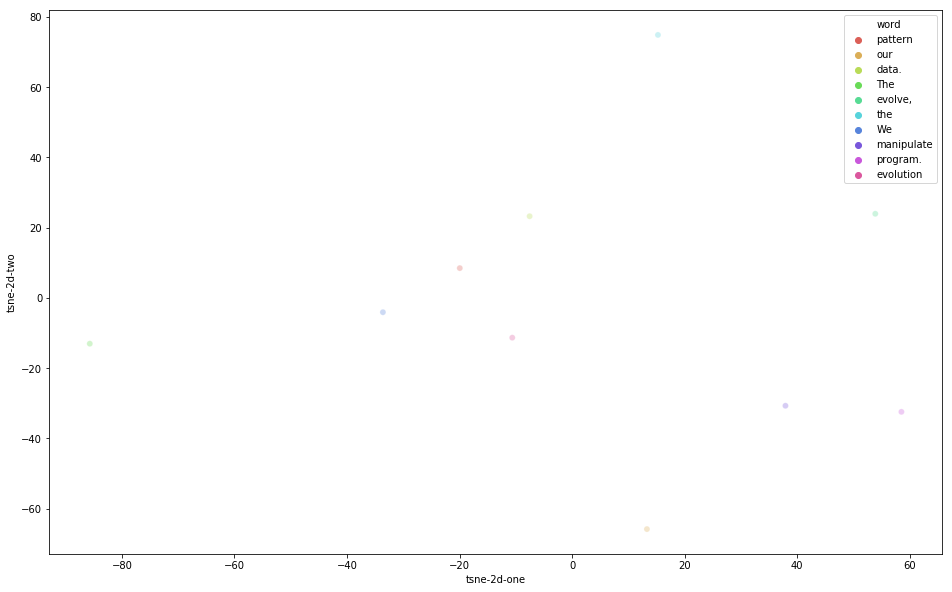

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
df['tsne-2d-one'] = tsne_results[:,0]
df['tsne-2d-two'] = tsne_results[:,1]
df['word'] = vocab

plt.figure(figsize=(16,10))
sns.scatterplot(
    x="tsne-2d-one", y="tsne-2d-two",
    hue="word",
    palette=sns.color_palette("hls", 10),
    data=df.head(10),
    legend="full",
    alpha=0.3
)